In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# -------------------------
# CONFIGURATION
# -------------------------
DATA_DIR = r"C:\Users\LENOVO\shivansh\plant_advisory\data\train"
EPOCHS = 40
LR = 0.005
BATCH_SIZE = 32

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -------------------------
# TRANSFORMS
# -------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# -------------------------
# LOAD DATASET
# -------------------------
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

# -------------------------
# MODEL SETUP
# -------------------------
model = models.resnet18(weights=None)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# -------------------------
# TRAINING LOOP
# -------------------------
best_loss = float("inf")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    total_images = 0

    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total_images += images.size(0)

        # Print progress every 1000 images
        if total_images >= 1000 and total_images % 1000 < BATCH_SIZE:
            print(f"Processed {total_images} images — Current Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch Loss: {epoch_loss:.4f}")

    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), "best_cnn_model.pth")
        print("Saved best model!")

print("\nTraining Completed.")
print("Best model saved as best_cnn_model.pth")


Using device: cuda
Number of classes: 38

=== Epoch 1/40 ===
Processed 1024 images — Current Loss: 3.8248
Processed 2016 images — Current Loss: 3.6067
Processed 3008 images — Current Loss: 3.4830
Processed 4000 images — Current Loss: 3.0167
Processed 5024 images — Current Loss: 3.3630
Processed 6016 images — Current Loss: 3.3168
Processed 7008 images — Current Loss: 3.0986
Processed 8000 images — Current Loss: 3.0787
Processed 9024 images — Current Loss: 3.1708
Processed 10016 images — Current Loss: 3.0864
Processed 11008 images — Current Loss: 2.9035
Processed 12000 images — Current Loss: 2.8636


KeyboardInterrupt: 

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# ============================================================
# 🔧 CONFIGURATION
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

data_dir = r"C:\Users\LENOVO\shivansh\plant_advisory\data"
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "valid")
test_dir  = os.path.join(data_dir, "test")

batch_size = 32
epochs = 30
lr = 1e-3
progress_step = 1024   # update after every 1024 images

# ============================================================
# 📸 DATA TRANSFORMS
# ============================================================
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ============================================================
# 📂 DATASETS & LOADERS
# ============================================================
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data   = datasets.ImageFolder(val_dir, transform=val_test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

num_classes = len(train_data.classes)
print(f"🧩 Found {num_classes} classes.")

# ============================================================
# 🧠 MODEL - RESNET18
# ============================================================
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model = model.to(device)

# ============================================================
# ⚙️ LOSS, OPTIMIZER, SCHEDULER
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# ============================================================
# 🏋️‍♂️ TRAINING LOOP (with 1024-image progress updates)
# ============================================================
train_losses, val_losses, val_accs = [], [], []
best_val_loss = float('inf')
patience, patience_counter = 3, 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    processed_images = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size_now = images.size(0)
        running_loss += loss.item() * batch_size_now
        processed_images += batch_size_now

        # 🔔 Update every 1024 images
        if processed_images % progress_step < batch_size_now:
            avg_partial_train_loss = running_loss / processed_images

            # quick val check
            model.eval()
            val_temp_loss = 0.0
            with torch.no_grad():
                for v_images, v_labels in val_loader:
                    v_images, v_labels = v_images.to(device), v_labels.to(device)
                    val_temp_loss += criterion(model(v_images), v_labels).item() * v_images.size(0)
                    break  # only 1 mini validation check

            avg_val_temp = val_temp_loss / batch_size
            print(f"🔄 Epoch {epoch+1} | Processed {processed_images}/{len(train_data)} images "
                  f"| Train Loss: {avg_partial_train_loss:.4f} | Val Loss: {avg_val_temp:.4f}")

            model.train()

    # -------- End of Epoch Validation --------
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            val_loss += criterion(model(images), labels).item() * images.size(0)
            _, preds = torch.max(model(images), 1)
            correct += torch.sum(preds == labels).item()

    avg_train_loss = running_loss / len(train_data)
    avg_val_loss   = val_loss / len(val_data)
    val_acc        = correct / len(val_data)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"📘 Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_cnn_model.pth")
        patience_counter = 0
        print("💾 Model improved → saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏸ Early stopping triggered.")
            break

print("\n🏁 Training complete.")
print(f"Best validation loss: {best_val_loss:.4f}")


🚀 Using device: cuda
🧩 Found 38 classes.
🔄 Epoch 1 | Processed 1024/70294 images | Train Loss: 3.3873 | Val Loss: 3.4308
🔄 Epoch 1 | Processed 2048/70294 images | Train Loss: 3.0382 | Val Loss: 2.2477
🔄 Epoch 1 | Processed 3072/70294 images | Train Loss: 2.6798 | Val Loss: 2.2600
🔄 Epoch 1 | Processed 4096/70294 images | Train Loss: 2.4274 | Val Loss: 1.7703
🔄 Epoch 1 | Processed 5120/70294 images | Train Loss: 2.2300 | Val Loss: 1.7275
🔄 Epoch 1 | Processed 6144/70294 images | Train Loss: 2.0805 | Val Loss: 1.7437
🔄 Epoch 1 | Processed 7168/70294 images | Train Loss: 1.9461 | Val Loss: 1.6537
🔄 Epoch 1 | Processed 8192/70294 images | Train Loss: 1.8424 | Val Loss: 1.3168
🔄 Epoch 1 | Processed 9216/70294 images | Train Loss: 1.7630 | Val Loss: 1.6186
🔄 Epoch 1 | Processed 10240/70294 images | Train Loss: 1.6995 | Val Loss: 1.0620
🔄 Epoch 1 | Processed 11264/70294 images | Train Loss: 1.6365 | Val Loss: 1.1530
🔄 Epoch 1 | Processed 12288/70294 images | Train Loss: 1.5819 | Val Loss: 0.9

In [5]:
torch.save(model.state_dict(), "best_cnn_model.pth")
print("💾 Saved current model as best_cnn_model_final.pth")


💾 Saved current model as best_cnn_model_final.pth


In [10]:
# ✅ Create a fresh copy
model_copy = CNNModel(num_classes=len(train_data.classes)).to(device)

# ✅ Load weights from your trained model
model_copy.load_state_dict(torch.load("best_cnn_model.pth", map_location=device))

print("🧬 Copied model loaded successfully.")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19888\95668790.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_copy.load_state_dict(torch.load("best_cnn_model.pth", m

RuntimeError: Error(s) in loading state_dict for CNNModel:
	Missing key(s) in state_dict: "features.0.weight", "features.0.bias", "features.1.weight", "features.1.bias", "features.1.running_mean", "features.1.running_var", "features.4.weight", "features.4.bias", "features.5.weight", "features.5.bias", "features.5.running_mean", "features.5.running_var", "features.8.weight", "features.8.bias", "features.9.weight", "features.9.bias", "features.9.running_mean", "features.9.running_var", "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked", "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias". 

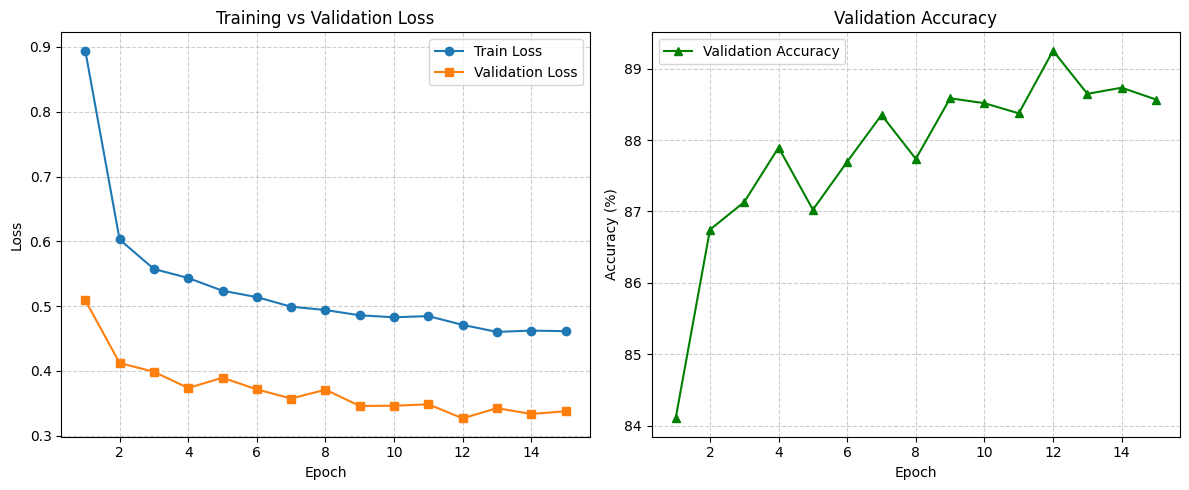

In [8]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)

plt.figure(figsize=(12, 5))

# 🔹 Plot Train vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs_ran + 1), val_losses, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 🔹 Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), [v * 100 for v in val_accs],
         label='Validation Accuracy', color='green', marker='^')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),  # adjust if your input size isn’t 128×128
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === recreate the same architecture ===
num_classes = len(train_data.classes)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # keep backbone frozen (same as before)

model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)

# === load your previously trained weights ===
checkpoint_path = "best_cnn_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
print("✅ Successfully loaded trained ResNet18 model.")


✅ Successfully loaded trained ResNet18 model.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19888\242488454.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

In [12]:
model_copy = copy.deepcopy(model)
print("🧩 Model copy created for further tuning.")


🧩 Model copy created for further tuning.


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# =========================================================
# 1️⃣ Setup: Create a copy model identical to the original
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(train_data.classes)
model_copy = models.resnet18(pretrained=True)

# Freeze all layers initially
for param in model_copy.parameters():
    param.requires_grad = False

# Replace and define classifier head (same as original)
model_copy.fc = nn.Sequential(
    nn.Linear(model_copy.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),  # slightly higher dropout for safety
    nn.Linear(256, num_classes)
)

# Load original best model weights
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
model_copy.load_state_dict(checkpoint)
model_copy = model_copy.to(device)
print("✅ Loaded original model weights into the copy model.")

# =========================================================
# 2️⃣ Unfreeze only layer4 + fc for fine-tuning
# =========================================================
for name, param in model_copy.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True
    else:
        param.requires_grad = False

trainable_params = [p for p in model_copy.parameters() if p.requires_grad]
print(f"🟢 Trainable parameters: {len(trainable_params)} layers (layer4 + fc)")

# =========================================================
# 3️⃣ Fine-tuning setup
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(trainable_params, lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)

epochs = 5
patience, patience_counter = 2, 0
best_val_loss = float('inf')

train_losses_ft, val_losses_ft, val_accs_ft = [], [], []

# =========================================================
# 4️⃣ Fine-tuning loop (on model_copy)
# =========================================================
for epoch in range(epochs):
    model_copy.train()
    running_loss = 0.0
    total_samples = 0

    print(f"\n🧠 Fine-tuning Epoch [{epoch+1}/{epochs}] ----------------")

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_copy(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

        # 🔹 Progress every 2048 images
        if total_samples % 2048 < images.size(0):
            avg_loss = running_loss / total_samples
            print(f"   🔹 {total_samples:>6} images processed | Avg Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(train_data)
    train_losses_ft.append(avg_train_loss)

    # ---------------- Validation ----------------
    model_copy.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_copy(images)
            val_loss += criterion(outputs, labels).item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()

    avg_val_loss = val_loss / len(val_data)
    val_losses_ft.append(avg_val_loss)
    val_acc = correct / len(val_data)
    val_accs_ft.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"📘 Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc*100:.2f}%")

    # 💾 Save improvements only
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_copy.state_dict(), "best_cnn_model_copy_finetuned.pth")
        patience_counter = 0
        print("💾 Model improved → saved as best_cnn_model_copy_finetuned.pth")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement ({patience_counter}/{patience})")
        if patience_counter >= patience:
            print("⏸ Early stopping triggered.")
            break

print("\n🏁 Fine-tuning complete.")
print(f"Best validation loss: {best_val_loss:.4f}")


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19888\669419644.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_cnn_model.pth", map_location=

✅ Loaded original model weights into the copy model.
🟢 Trainable parameters: 19 layers (layer4 + fc)

🧠 Fine-tuning Epoch [1/5] ----------------
   🔹   2048 images processed | Avg Loss: 0.6389
   🔹   4096 images processed | Avg Loss: 0.5978
   🔹   6144 images processed | Avg Loss: 0.5681
   🔹   8192 images processed | Avg Loss: 0.5417
   🔹  10240 images processed | Avg Loss: 0.5151
   🔹  12288 images processed | Avg Loss: 0.4973
   🔹  14336 images processed | Avg Loss: 0.4877
   🔹  16384 images processed | Avg Loss: 0.4765
   🔹  18432 images processed | Avg Loss: 0.4607
   🔹  20480 images processed | Avg Loss: 0.4491
   🔹  22528 images processed | Avg Loss: 0.4379
   🔹  24576 images processed | Avg Loss: 0.4293
   🔹  26624 images processed | Avg Loss: 0.4203
   🔹  28672 images processed | Avg Loss: 0.4120
   🔹  30720 images processed | Avg Loss: 0.4043
   🔹  32768 images processed | Avg Loss: 0.3956
   🔹  34816 images processed | Avg Loss: 0.3875
   🔹  36864 images processed | Avg Loss

C:\Users\LENOVO\shivansh\plant_advisory\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\LENOVO\shivansh\plant_advisory\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19888\3724090498.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defau

✅ Fine-tuned model loaded successfully.

🧾 Saved predictions → test_predictions_detailed.csv

🎯 Test Accuracy: 84.85%

📊 Classification Report:
                                        precision    recall  f1-score   support

                    Apple___Apple_scab       0.00      0.00      0.00         0
              Apple___Cedar_apple_rust       1.00      1.00      1.00         4
                          Apple___Scab       0.00      0.00      0.00         3
           Corn_(maize)___Common_rust_       1.00      1.00      1.00         3
   Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.00         0
                 Potato___Early_blight       1.00      1.00      1.00         5
                      Potato___healthy       1.00      1.00      1.00         2
                 Tomato___Early_blight       1.00      0.67      0.80         6
                  Tomato___Late_blight       0.00      0.00      0.00         0
                  Tomato___Target_Spot       0.00      

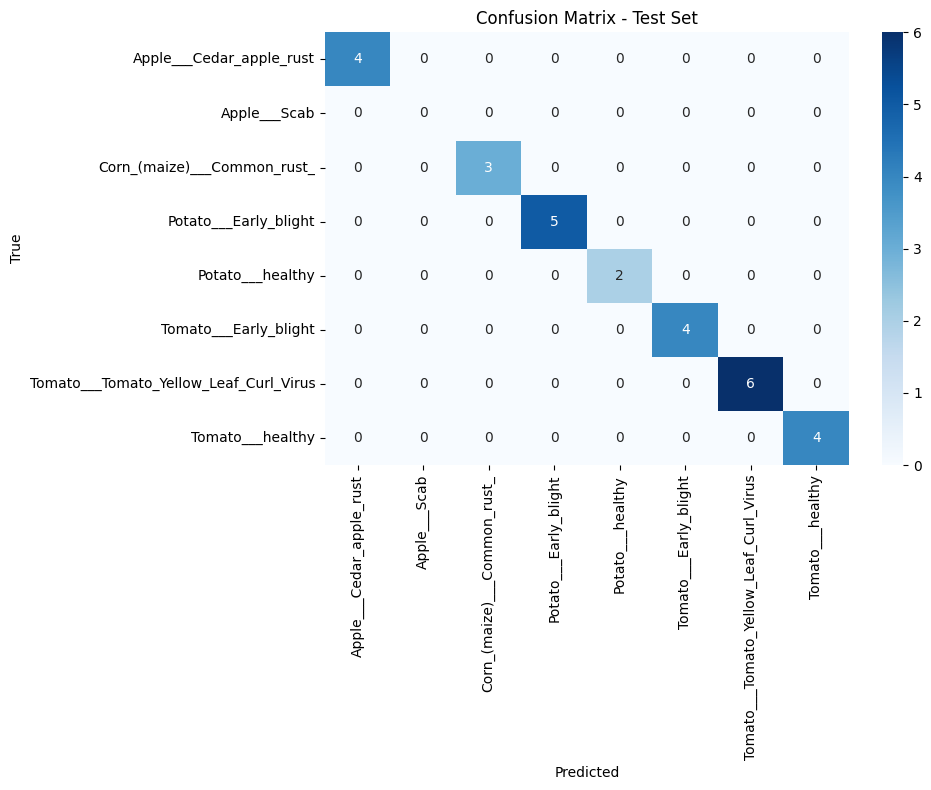

✅ Confusion matrix saved as 'confusion_matrix_test.png'.

🔍 Sample Predictions:
         Image_Name                  True_Label                     Predicted_Label  Correct
AppleCedarRust1.JPG    Apple___Cedar_apple_rust            Apple___Cedar_apple_rust     True
AppleCedarRust2.JPG    Apple___Cedar_apple_rust            Apple___Cedar_apple_rust     True
AppleCedarRust3.JPG    Apple___Cedar_apple_rust            Apple___Cedar_apple_rust     True
AppleCedarRust4.JPG    Apple___Cedar_apple_rust            Apple___Cedar_apple_rust     True
     AppleScab1.JPG                Apple___Scab                  Apple___Apple_scab    False
     AppleScab2.JPG                Apple___Scab                  Apple___Apple_scab    False
     AppleScab3.JPG                Apple___Scab Corn_(maize)___Northern_Leaf_Blight    False
CornCommonRust1.JPG Corn_(maize)___Common_rust_         Corn_(maize)___Common_rust_     True
CornCommonRust2.JPG Corn_(maize)___Common_rust_         Corn_(maize)___Common_rust_

In [16]:
import os
import re
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch import nn
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

# ---------------- SETTINGS ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dir = r"C:\Users\LENOVO\shivansh\plant_advisory\data\test"
model_path = "best_cnn_model_copy_finetuned.pth"
num_classes = len(train_data.classes)

# ---------------- MODEL ----------------
model = models.resnet18(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes)
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print("✅ Fine-tuned model loaded successfully.")

# ---------------- TRANSFORMS ----------------
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ---------------- HELPER ----------------
def infer_label_from_filename(filename: str):
    """
    Infers the true label from the image filename.
    Example: 'TomatoHealthy1.JPG' → 'Tomato___healthy'
    """
    name = filename.split('.')[0]
    name = re.sub(r'(\d+)$', '', name)  # remove trailing digits
    name = name.replace('_', '').replace('-', '')
    name = name.replace(' ', '').strip()

    mapping = {
        "AppleCedarRust": "Apple___Cedar_apple_rust",
        "AppleScab": "Apple___Scab",
        "AppleHealthy": "Apple___healthy",
        "CornCommonRust": "Corn_(maize)___Common_rust_",
        "CornGrayLeafSpot": "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
        "PotatoEarlyBlight": "Potato___Early_blight",
        "PotatoHealthy": "Potato___healthy",
        "SoybeanHealthy": "Soybean___healthy",
        "TomatoBacterialSpot": "Tomato___Bacterial_spot",
        "TomatoEarlyBlight": "Tomato___Early_blight",
        "TomatoTargetSpot": "Tomato___Target_Spot",
        "TomatoHealthy": "Tomato___healthy",
        "TomatoYellowCurlVirus": "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
        "CherryPowderyMildew": "Cherry_(including_sour)___Powdery_mildew",
        "GrapeBlackRot": "Grape___Black_rot"
    }

    for key, value in mapping.items():
        if key.lower() in name.lower():
            return value
    return "Unknown"

# ---------------- INFERENCE ----------------
results = []
for img_name in sorted(os.listdir(test_dir)):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(test_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
        predicted_label = train_data.classes[pred.item()]

    true_label = infer_label_from_filename(img_name)
    results.append({
        "Image_Name": img_name,
        "True_Label": true_label,
        "Predicted_Label": predicted_label,
        "Correct": true_label == predicted_label
    })

# ---------------- SAVE & REPORT ----------------
df = pd.DataFrame(results)
df.to_csv("test_predictions_detailed.csv", index=False)
print(f"\n🧾 Saved predictions → test_predictions_detailed.csv")

# Compute metrics (excluding 'Unknown')
filtered = df[df["True_Label"] != "Unknown"]
y_true = filtered["True_Label"]
y_pred = filtered["Predicted_Label"]

acc = (filtered["Correct"].sum() / len(filtered)) * 100
print(f"\n🎯 Test Accuracy: {acc:.2f}%")

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

# ---------------- CONFUSION MATRIX ----------------
cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(set(y_true)),
            yticklabels=sorted(set(y_true)))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("confusion_matrix_test.png")
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix_test.png'.")

# ---------------- SAMPLE OUTPUT ----------------
print("\n🔍 Sample Predictions:")
print(df.head(10).to_string(index=False))
